Import Statements

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import inflection 
from scipy import stats
from boruta import BorutaPy
from category_encoders import OneHotEncoder
from IPython.display import Image
from IPython.core.display import HTML

from xgboost  import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.svm          import SVC
from sklearn.dummy        import DummyClassifier
from sklearn.ensemble     import RandomForestClassifier
from sklearn.neighbors    import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics         import balanced_accuracy_score, precision_score, classification_report
from sklearn.metrics         import recall_score, f1_score, make_scorer, cohen_kappa_score
from sklearn.preprocessing   import MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold


Helper Function

In [2]:
def ml_scores(model_name, y_true, y_pred):
    
    accuracy = balanced_accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    
    return pd.DataFrame({'Balanced Accuracy': np.round(accuracy, 3), 
                         'Precision': np.round(precision, 3), 
                         'Recall': np.round(recall, 3),
                         'F1': np.round(f1, 3),
                         'Kappa': np.round(kappa, 3)}, 
                        index=[model_name])

Data Description

In [3]:
data=pd.read_csv('..\\data\\fraud_0.1origbase.csv')

In [4]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,283,CASH_IN,210329.84,C1159819632,3778062.79,3988392.64,C1218876138,1519266.60,1308936.76,0,0
1,132,CASH_OUT,215489.19,C1372369468,21518.00,0.00,C467105520,6345756.55,6794954.89,0,0
2,355,DEBIT,4431.05,C1059822709,20674.00,16242.95,C76588246,80876.56,85307.61,0,0
3,135,CASH_OUT,214026.20,C1464960643,46909.73,0.00,C1059379810,13467450.36,13681476.56,0,0
4,381,CASH_OUT,8858.45,C831134427,0.00,0.00,C579876929,1667180.58,1676039.03,0,0


In [5]:
data.describe

<bound method NDFrame.describe of         step      type     amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0        283   CASH_IN  210329.84  C1159819632     3778062.79      3988392.64   
1        132  CASH_OUT  215489.19  C1372369468       21518.00            0.00   
2        355     DEBIT    4431.05  C1059822709       20674.00        16242.95   
3        135  CASH_OUT  214026.20  C1464960643       46909.73            0.00   
4        381  CASH_OUT    8858.45   C831134427           0.00            0.00   
...      ...       ...        ...          ...            ...             ...   
636257   351  CASH_OUT   28761.10   C742050657           0.00            0.00   
636258   184  CASH_OUT  167820.71   C561181412       62265.00            0.00   
636259    35   PAYMENT    8898.12  C1773417333       30808.00        21909.88   
636260   277  CASH_OUT  176147.90  C1423233247       83669.00            0.00   
636261   304  CASH_OUT   95142.89   C874575079           0.00            0.

In [6]:
data.tail()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
636257,351,CASH_OUT,28761.10,C742050657,0.0,0.00,C568407561,328534.52,357295.62,0,0
636258,184,CASH_OUT,167820.71,C561181412,62265.0,0.00,C1852953580,106429.48,274250.18,0,0
636259,35,PAYMENT,8898.12,C1773417333,30808.0,21909.88,M445701551,0.00,0.00,0,0
636260,277,CASH_OUT,176147.90,C1423233247,83669.0,0.00,C1328739120,0.00,176147.90,0,0
636261,304,CASH_OUT,95142.89,C874575079,0.0,0.00,C666451134,431380.07,526522.96,0,0


In [7]:
data.shape,data.size

((636262, 11), 6998882)

In [8]:
data.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,636262.000000,6.362620e+05,6.362620e+05,6.362620e+05,6.362620e+05,6.362620e+05,636262.000000,636262.000000
mean,242.931935,1.800585e+05,8.317937e+05,8.528354e+05,1.096212e+06,1.221809e+06,0.001290,0.000003
std,142.330857,6.069714e+05,2.885636e+06,2.921296e+06,3.375389e+06,3.656213e+06,0.035898,0.001773
min,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,155.000000,1.340742e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
50%,238.000000,7.481577e+04,1.423900e+04,0.000000e+00,1.315397e+05,2.147127e+05,0.000000,0.000000
75%,334.000000,2.084988e+05,1.072998e+05,1.435652e+05,9.384820e+05,1.109230e+06,0.000000,0.000000
max,742.000000,5.722962e+07,4.368662e+07,4.367380e+07,3.551855e+08,3.555534e+08,1.000000,1.000000


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636262 entries, 0 to 636261
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            636262 non-null  int64  
 1   type            636262 non-null  object 
 2   amount          636262 non-null  float64
 3   nameOrig        636262 non-null  object 
 4   oldbalanceOrg   636262 non-null  float64
 5   newbalanceOrig  636262 non-null  float64
 6   nameDest        636262 non-null  object 
 7   oldbalanceDest  636262 non-null  float64
 8   newbalanceDest  636262 non-null  float64
 9   isFraud         636262 non-null  int64  
 10  isFlaggedFraud  636262 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 53.4+ MB


Columns

step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount - amount of the transaction in local currency.

nameOrig - customer who started the transaction

oldbalanceOrg - initial balance before the transaction

newbalanceOrig - new balance after the transaction.

nameDest - customer who is the recipient of the transaction

oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

Column Renaming

In [10]:
oldColumns=data.columns.tolist()
oldColumns

['step',
 'type',
 'amount',
 'nameOrig',
 'oldbalanceOrg',
 'newbalanceOrig',
 'nameDest',
 'oldbalanceDest',
 'newbalanceDest',
 'isFraud',
 'isFlaggedFraud']

In [11]:
new_name_function=lambda x: inflection.underscore(x)
newColumns=list(map(new_name_function,oldColumns))
newColumns

['step',
 'type',
 'amount',
 'name_orig',
 'oldbalance_org',
 'newbalance_orig',
 'name_dest',
 'oldbalance_dest',
 'newbalance_dest',
 'is_fraud',
 'is_flagged_fraud']

In [12]:
data.columns=newColumns
data.columns

Index(['step', 'type', 'amount', 'name_orig', 'oldbalance_org',
       'newbalance_orig', 'name_dest', 'oldbalance_dest', 'newbalance_dest',
       'is_fraud', 'is_flagged_fraud'],
      dtype='object')

In [13]:
data.head()

,step,type,amount,name_orig,oldbalance_org,newbalance_orig,name_dest,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud
0,283,CASH_IN,210329.84,C1159819632,3778062.79,3988392.64,C1218876138,1519266.60,1308936.76,0,0
1,132,CASH_OUT,215489.19,C1372369468,21518.00,0.00,C467105520,6345756.55,6794954.89,0,0
2,355,DEBIT,4431.05,C1059822709,20674.00,16242.95,C76588246,80876.56,85307.61,0,0
3,135,CASH_OUT,214026.20,C1464960643,46909.73,0.00,C1059379810,13467450.36,13681476.56,0,0
4,381,CASH_OUT,8858.45,C831134427,0.00,0.00,C579876929,1667180.58,1676039.03,0,0


Checkout Null Values

In [14]:
data.isna().mean()

step                0.0
type                0.0
amount              0.0
name_orig           0.0
oldbalance_org      0.0
newbalance_orig     0.0
name_dest           0.0
oldbalance_dest     0.0
newbalance_dest     0.0
is_fraud            0.0
is_flagged_fraud    0.0
dtype: float64

The above line of code shows that there are no null values.

Change Data Types

In [15]:
data['is_fraud'] = data['is_fraud'].map({1: 'yes', 0: 'no'})
data['is_flagged_fraud'] = data['is_flagged_fraud'].map({1: 'yes', 0: 'no'})

Attribute Statistics

In [16]:
num_attributes = data.select_dtypes(exclude='object')
cat_attributes = data.select_dtypes(include='object')

In [17]:
num_attributes

,step,amount,oldbalance_org,newbalance_orig,oldbalance_dest,newbalance_dest
0,283,210329.84,3778062.79,3988392.64,1519266.60,1308936.76
1,132,215489.19,21518.00,0.00,6345756.55,6794954.89
2,355,4431.05,20674.00,16242.95,80876.56,85307.61
3,135,214026.20,46909.73,0.00,13467450.36,13681476.56
4,381,8858.45,0.00,0.00,1667180.58,1676039.03
...,...,...,...,...,...,...
636257,351,28761.10,0.00,0.00,328534.52,357295.62
636258,184,167820.71,62265.00,0.00,106429.48,274250.18
636259,35,8898.12,30808.00,21909.88,0.00,0.00
636260,277,176147.90,83669.00,0.00,0.00,176147.90


In [18]:
cat_attributes

,type,name_orig,name_dest,is_fraud,is_flagged_fraud
0,CASH_IN,C1159819632,C1218876138,no,no
1,CASH_OUT,C1372369468,C467105520,no,no
2,DEBIT,C1059822709,C76588246,no,no
3,CASH_OUT,C1464960643,C1059379810,no,no
4,CASH_OUT,C831134427,C579876929,no,no
...,...,...,...,...,...
636257,CASH_OUT,C742050657,C568407561,no,no
636258,CASH_OUT,C561181412,C1852953580,no,no
636259,PAYMENT,C1773417333,M445701551,no,no
636260,CASH_OUT,C1423233247,C1328739120,no,no


In [19]:
description=num_attributes.describe().T

In [20]:
description

,count,mean,std,min,25%,50%,75%,max
step,636262.0,2.429319e+02,1.423309e+02,1.0,155.000,238.000,3.340000e+02,7.420000e+02
amount,636262.0,1.800585e+05,6.069714e+05,0.0,13407.425,74815.770,2.084988e+05,5.722962e+07
oldbalance_org,636262.0,8.317937e+05,2.885636e+06,0.0,0.000,14239.000,1.072998e+05,4.368662e+07
newbalance_orig,636262.0,8.528354e+05,2.921296e+06,0.0,0.000,0.000,1.435652e+05,4.367380e+07
oldbalance_dest,636262.0,1.096212e+06,3.375389e+06,0.0,0.000,131539.745,9.384820e+05,3.551855e+08
newbalance_dest,636262.0,1.221809e+06,3.656213e+06,0.0,0.000,214712.725,1.109230e+06,3.555534e+08


In [21]:
description['range']=num_attributes.max()-num_attributes.min()
description['variation coeffecient']=(num_attributes.std() / num_attributes.mean()) *100
description['skewness']=num_attributes.skew()
description['kurtosis']=num_attributes.kurtosis()

In [22]:
description

,count,mean,std,min,25%,50%,75%,max,range,variation coeffecient,skewness,kurtosis
step,636262.0,2.429319e+02,1.423309e+02,1.0,155.000,238.000,3.340000e+02,7.420000e+02,7.410000e+02,58.588780,0.375052,0.324437
amount,636262.0,1.800585e+05,6.069714e+05,0.0,13407.425,74815.770,2.084988e+05,5.722962e+07,5.722962e+07,337.096714,29.577107,1546.661043
oldbalance_org,636262.0,8.317937e+05,2.885636e+06,0.0,0.000,14239.000,1.072998e+05,4.368662e+07,4.368662e+07,346.917323,5.243428,32.766036
newbalance_orig,636262.0,8.528354e+05,2.921296e+06,0.0,0.000,0.000,1.435652e+05,4.367380e+07,4.367380e+07,342.539297,5.173614,31.932547
oldbalance_dest,636262.0,1.096212e+06,3.375389e+06,0.0,0.000,131539.745,9.384820e+05,3.551855e+08,3.551855e+08,307.913810,20.622388,1074.335293
newbalance_dest,636262.0,1.221809e+06,3.656213e+06,0.0,0.000,214712.725,1.109230e+06,3.555534e+08,3.555534e+08,299.245961,19.623903,928.694204


Some points of analysis after the EDA:
* In general, a coefficient of variation between 20–30 is acceptable, while a COV greater than 30 is unacceptable. All the data has a coeffecient of variation much greater than 20-30 so thus the data is non homogenous
* The step variable starts from min=1 to max=742 so (1,742) hours = 30 days
* 50% of the newbalance_orig is 0.This implies that maybe there are some transactions that didn't reach their destination.
* Skewness also includes the extremes of the dataset instead of focusing only on the average. Hence, investors take note of skewness while estimating the distribution of returns on investments.
Since this dataset is positively skewed this implies that there are few transactions with high values and majority of transactions have relatively low values.
Also, this means that this distribution is right skewed and is tepered towards the right side.
* Kurtosis in a dataset gives us the degree of outliers and thus a positive kurtosis in this dataset gives us a more tailed distribution as compared to the nrmal distribution and thus consists of more outliers.

In [23]:
cat_attributes.describe().T

,count,unique,top,freq
type,636262,5,CASH_OUT,224216
name_orig,636262,636171,C334643493,2
name_dest,636262,457224,C2083562754,14
is_fraud,636262,2,no,635441
is_flagged_fraud,636262,2,no,636260


Categorical Value Analysis
* Majority type of transactins are CASH-OUT with a frequency of 224216
* There's a lot of variability in name_orig as we can see that there are 636171 unique values so it will be difficult to one hot encode it.
* The analysis notes that there are fewer unique values in the "name_orig" column compared to the "name_dest" column. This implies that there are more users sending money than there are users receiving money. While this information is useful, it also suggests that one-hot encoding might not be as helpful, especially for the "name_orig" column, given the large variability
* There's more is_flagged_fraud than is_fraud which implies that the current method can't recognize the fraud efficiently.

Feature Engineering

In [24]:
dataframe1=data.copy()

Mind Map

![mind map image](..\\images\Fraud-mindmap.png)


Hypothesis Creation 

1. User

90% of the twentyone-year-old users did a fraud transaction.

The majority fraud transaction occours for the same initial letter user.

The fraud amount is greater than 10.000.

The 60% of the age is greater than 30 year old.

2. Type

60% of fraud transaction occours using cash-out-type method.

The majority transfers occours using tranfers-type method.

Values greater than 100.000 occours using transfers-type method.

Payment type occurs with values lower than 100.000

3. Origin and Destination Transactions

60% of the difference between origin and destination transactions is equal to 0 for frauds.

Origin values are greater than destiny values for fraud transaction.

4. Time

Fraud transactions occours at least in 3 days.

40% of the cash-out transactions occours less than 1 day.

60% of the transaction less than 100.000 occours at least 10 days.

The transactions greater than 10.000 occours at most in 2 weeks.

Final Hypothesis List

The majority fraud transiction occours for the same initial letter user.

All the fraud amount is greater than 10.000.

60% of fraud transaction occours using cash-out-type method.

The majority transfers occours using tranfers-type method.

Fraud transactions occours at least in 3 days.

Feature Engineering

step_days: It creates a new column 'step_days' in the DataFrame by dividing the 'step' column by 24. This assumes that each step represents 1 hour, so 'step_days' would represent the equivalent time in days.

step_weeks: It creates another new column 'step_weeks' by dividing the 'step' column by (24 * 7), assuming each step represents 1 hour and there are 24 hours in a day and 7 days in a week.

diff_new_old_balance:It calculates the difference between the new balance ('newbalance_orig') and the old balance ('oldbalance_org') for the origin of the transaction.

diff_new_old_destiny: It calculates the difference between the new balance ('newbalance_dest') and the old balance ('oldbalance_dest') for the destination of the transaction.

name_orig: It creates a new column 'name_orig' in the DataFrame, taking the first character of each entry in the 'name_orig' column.

name_dest: It creates a new column 'name_dest' in the DataFrame, taking the first character of each entry in the 'name_dest' column.

In [25]:
# step
dataframe1['step_days'] = dataframe1['step'].apply(lambda i: i/24)
dataframe1['step_weeks'] = dataframe1['step'].apply(lambda i: i/(24*7))

# difference between initial balance before the transaction and new balance after the transaction
dataframe1['diff_new_old_balance'] = dataframe1['newbalance_orig'] - dataframe1['oldbalance_org']

# difference between initial balance recipient before the transaction and new balance recipient after the transaction.
dataframe1['diff_new_old_dest'] = dataframe1['newbalance_dest'] - dataframe1['oldbalance_dest']

# name orig and name dest
dataframe1['name_orig'] = dataframe1['name_orig'].apply(lambda i: i[0])
dataframe1['name_dest'] = dataframe1['name_dest'].apply(lambda i: i[0])

In [26]:
dataframe1

,step,type,amount,name_orig,oldbalance_org,newbalance_orig,name_dest,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud,step_days,step_weeks,diff_new_old_balance,diff_new_old_dest
0,283,CASH_IN,210329.84,C,3778062.79,3988392.64,C,1519266.60,1308936.76,no,no,11.791667,1.684524,210329.85,-210329.84
1,132,CASH_OUT,215489.19,C,21518.00,0.00,C,6345756.55,6794954.89,no,no,5.500000,0.785714,-21518.00,449198.34
2,355,DEBIT,4431.05,C,20674.00,16242.95,C,80876.56,85307.61,no,no,14.791667,2.113095,-4431.05,4431.05
3,135,CASH_OUT,214026.20,C,46909.73,0.00,C,13467450.36,13681476.56,no,no,5.625000,0.803571,-46909.73,214026.20
4,381,CASH_OUT,8858.45,C,0.00,0.00,C,1667180.58,1676039.03,no,no,15.875000,2.267857,0.00,8858.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
636257,351,CASH_OUT,28761.10,C,0.00,0.00,C,328534.52,357295.62,no,no,14.625000,2.089286,0.00,28761.10
636258,184,CASH_OUT,167820.71,C,62265.00,0.00,C,106429.48,274250.18,no,no,7.666667,1.095238,-62265.00,167820.70
636259,35,PAYMENT,8898.12,C,30808.00,21909.88,M,0.00,0.00,no,no,1.458333,0.208333,-8898.12,0.00
636260,277,CASH_OUT,176147.90,C,83669.00,0.00,C,0.00,176147.90,no,no,11.541667,1.648810,-83669.00,176147.90


In [27]:
dataframe2=dataframe1.copy()

Response Variable

Using the Seaborn library to create a countplot for the 'is_fraud' column in the DataFrame dataframe2. Additionally, it annotates each bar in the plot with the percentage of the total dataset that it represents.It counts the occurrences of each unique value in the 'is_fraud' column and represents them as bars.

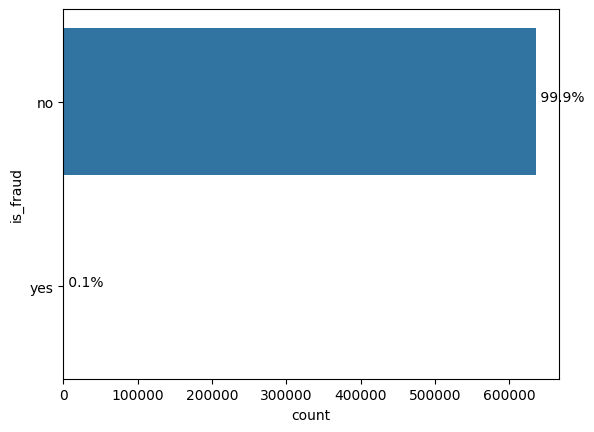

In [28]:
ax = sns.countplot(y='is_fraud', data=dataframe2);

total = dataframe2['is_fraud'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

* sns.countplot: This is a function from the Seaborn library used to create a bar plot that shows the counts of unique values in a categorical variable. In this case, it's creating a count plot for the 'is_fraud' column.
* y='is_fraud': This specifies that the 'is_fraud' column should be plotted on the y-axis.
* data=dataframe2: This specifies the DataFrame from which the data should be taken.
* total = dataframe2['is_fraud'].size
total: This variable is assigned the total number of rows in the 'is_fraud' column, which represents the total number of transactions in the DataFrame.
* for p in ax.patches:: This loop iterates through each rectangular patch (bar) in the count plot.
* percentage = ' {:.1f}%'.format(100 * p.get_width()/total): This line calculates the percentage of each category (fraud or non-fraud) and formats it as a string with one decimal place.
* x = p.get_x() + p.get_width() + 0.02: This sets the x-coordinate for the annotation, placing it just to the right of the bar.
* y = p.get_y() + p.get_height()/2: This sets the y-coordinate for the annotation, placing it at the center height of the bar.
* ax.annotate(percentage, (x, y)): This annotates each bar with its corresponding percentage, placing the text at the specified coordinates.

Numerical Variables Visualisation

create a grid of histograms for numerical attributes in the DataFrame dataframe2.

The kde=True argument adds a kernel density estimate to the plot.- smoothing of probability density function

In [29]:
'''num_attributes = dataframe2.select_dtypes(exclude='object')
columns = num_attributes.columns.tolist()
j = 1

# Specify the number of rows and columns for the subplot grid
num_rows = 2
num_cols = 5
plt.figure(figsize=(15, 6))
# Create the subplot grid
plt.figure(figsize=(15, 6))

for column in columns:
    plt.subplot(num_rows, num_cols, j)
    sns.histplot(num_attributes[column], kde=True)  # Use sns.histplot instead of sns.displot
    
    plt.title(column)  # Add title to each subplot
    plt.xlabel('')  # Clear x-axis label for better visualization
    
    j += 1

plt.tight_layout()  # Adjust layout for better spacing
plt.show()'''

"num_attributes = dataframe2.select_dtypes(exclude='object')\ncolumns = num_attributes.columns.tolist()\nj = 1\n\n# Specify the number of rows and columns for the subplot grid\nnum_rows = 2\nnum_cols = 5\nplt.figure(figsize=(15, 6))\n# Create the subplot grid\nplt.figure(figsize=(15, 6))\n\nfor column in columns:\n    plt.subplot(num_rows, num_cols, j)\n    sns.histplot(num_attributes[column], kde=True)  # Use sns.histplot instead of sns.displot\n    \n    plt.title(column)  # Add title to each subplot\n    plt.xlabel('')  # Clear x-axis label for better visualization\n    \n    j += 1\n\nplt.tight_layout()  # Adjust layout for better spacing\nplt.show()"

Categorical Atributes Visualisation

creates a grid of countplots for categorical attributes in the DataFrame dataframe2

Plots a countplot for the current categorical attribute using Seaborn's countplot. It displays the count of each category.

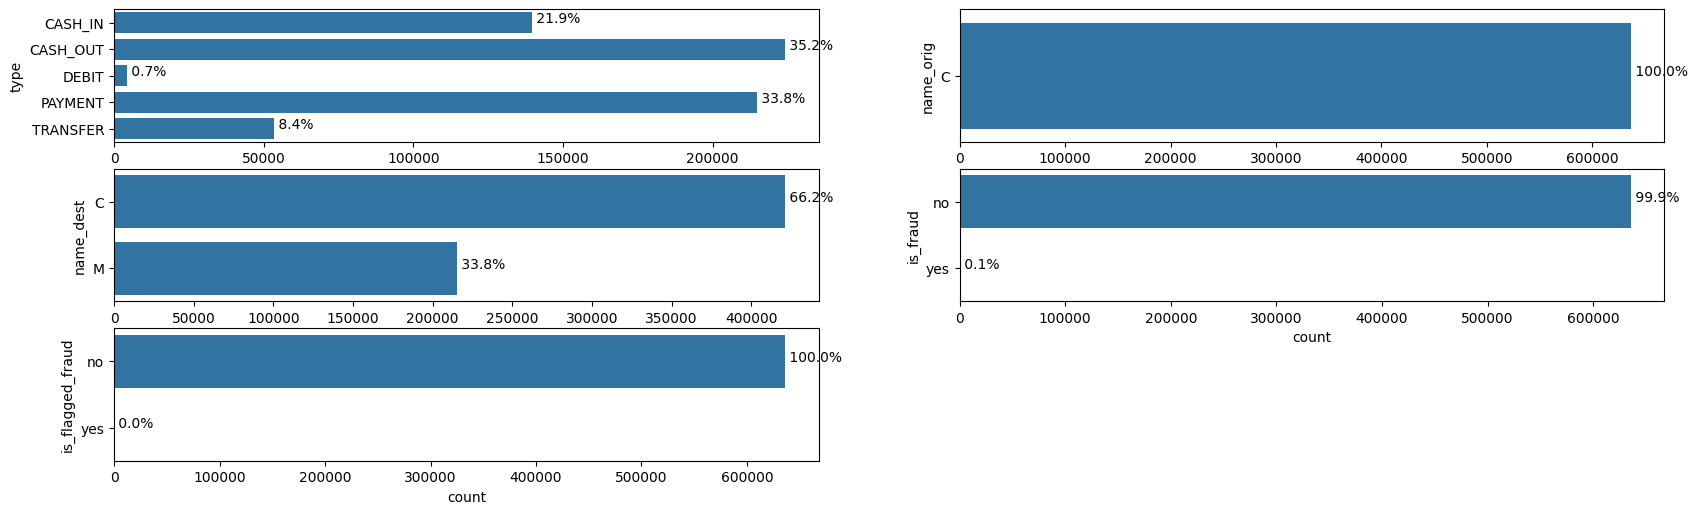

In [30]:
cat_attributes = dataframe2.select_dtypes(include='object')
columns = cat_attributes.columns.tolist()
j = 1
plt.figure(figsize=(20, 10))
for column in columns:
    plt.subplot(5, 2, j)
    ax = sns.countplot(y=column, data=cat_attributes)
    
    total = cat_attributes[column].size
    for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))
    
    j += 1

Bivariate Analysis

Hypothesis 1: Majority of fraud transaction occurs by the same user

TRUE: This hypothesis stands true as the user origin and the destination have the same initial letters.

creates a countplot using Seaborn to visualize the distribution of the 'name_orig' variable in the DataFrame aux1, which is a subset of dataframe2 where the 'is_fraud' column has the value 'yes'.

aux1 is a new DataFrame that includes only the rows from dataframe2 where the value in the 'is_fraud' column is 'yes'. This subset represents transactions labeled as fraudulent.

In [31]:
aux2=dataframe2[dataframe2['is_fraud']=='no']
aux2

,step,type,amount,name_orig,oldbalance_org,newbalance_orig,name_dest,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud,step_days,step_weeks,diff_new_old_balance,diff_new_old_dest
0,283,CASH_IN,210329.84,C,3778062.79,3988392.64,C,1519266.60,1308936.76,no,no,11.791667,1.684524,210329.85,-210329.84
1,132,CASH_OUT,215489.19,C,21518.00,0.00,C,6345756.55,6794954.89,no,no,5.500000,0.785714,-21518.00,449198.34
2,355,DEBIT,4431.05,C,20674.00,16242.95,C,80876.56,85307.61,no,no,14.791667,2.113095,-4431.05,4431.05
3,135,CASH_OUT,214026.20,C,46909.73,0.00,C,13467450.36,13681476.56,no,no,5.625000,0.803571,-46909.73,214026.20
4,381,CASH_OUT,8858.45,C,0.00,0.00,C,1667180.58,1676039.03,no,no,15.875000,2.267857,0.00,8858.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
636257,351,CASH_OUT,28761.10,C,0.00,0.00,C,328534.52,357295.62,no,no,14.625000,2.089286,0.00,28761.10
636258,184,CASH_OUT,167820.71,C,62265.00,0.00,C,106429.48,274250.18,no,no,7.666667,1.095238,-62265.00,167820.70
636259,35,PAYMENT,8898.12,C,30808.00,21909.88,M,0.00,0.00,no,no,1.458333,0.208333,-8898.12,0.00
636260,277,CASH_OUT,176147.90,C,83669.00,0.00,C,0.00,176147.90,no,no,11.541667,1.648810,-83669.00,176147.90


<Axes: xlabel='count', ylabel='name_orig'>

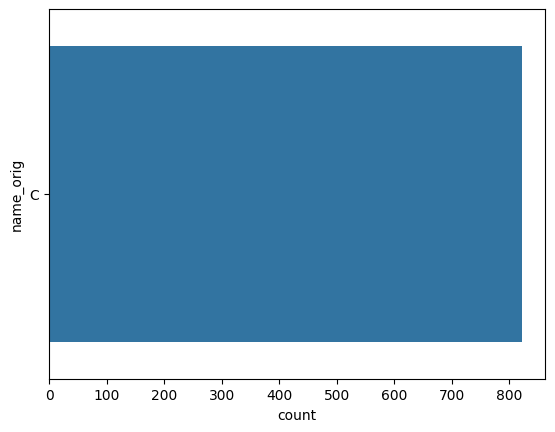

In [32]:
aux1=dataframe2[dataframe2['is_fraud']=='yes']
sns.countplot(y="name_orig",data=aux1)

<Axes: xlabel='count', ylabel='name_dest'>

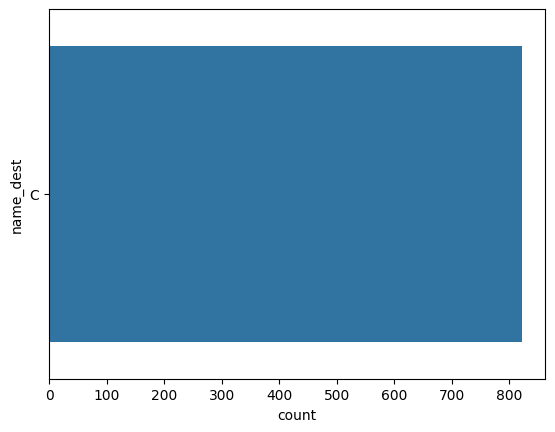

In [33]:
sns.countplot(y='name_dest', data=aux1)

In [34]:
aux1

,step,type,amount,name_orig,oldbalance_org,newbalance_orig,name_dest,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud,step_days,step_weeks,diff_new_old_balance,diff_new_old_dest
720,451,CASH_OUT,9265.43,C,9265.43,0.0,C,0.00,9265.43,yes,no,18.791667,2.684524,-9265.43,9265.43
1124,48,CASH_OUT,337974.21,C,337974.21,0.0,C,0.00,337974.21,yes,no,2.000000,0.285714,-337974.21,337974.21
1313,686,CASH_OUT,134227.05,C,134227.05,0.0,C,2789107.98,2923335.03,yes,no,28.583333,4.083333,-134227.05,134227.05
2381,567,TRANSFER,175203.45,C,175203.45,0.0,C,0.00,0.00,yes,no,23.625000,3.375000,-175203.45,0.00
3919,629,CASH_OUT,1650.08,C,1650.08,0.0,C,0.00,1650.08,yes,no,26.208333,3.744048,-1650.08,1650.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
633586,409,TRANSFER,71921.70,C,71921.70,0.0,C,0.00,0.00,yes,no,17.041667,2.434524,-71921.70,0.00
633927,523,TRANSFER,7603589.38,C,7603589.38,0.0,C,0.00,0.00,yes,no,21.791667,3.113095,-7603589.38,0.00
633950,684,TRANSFER,537025.01,C,537025.01,0.0,C,0.00,0.00,yes,no,28.500000,4.071429,-537025.01,0.00
634851,492,TRANSFER,1059682.92,C,1059682.92,0.0,C,0.00,0.00,yes,no,20.500000,2.928571,-1059682.92,0.00


In [35]:
aux1.head()

,step,type,amount,name_orig,oldbalance_org,newbalance_orig,name_dest,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud,step_days,step_weeks,diff_new_old_balance,diff_new_old_dest
720,451,CASH_OUT,9265.43,C,9265.43,0.0,C,0.00,9265.43,yes,no,18.791667,2.684524,-9265.43,9265.43
1124,48,CASH_OUT,337974.21,C,337974.21,0.0,C,0.00,337974.21,yes,no,2.000000,0.285714,-337974.21,337974.21
1313,686,CASH_OUT,134227.05,C,134227.05,0.0,C,2789107.98,2923335.03,yes,no,28.583333,4.083333,-134227.05,134227.05
2381,567,TRANSFER,175203.45,C,175203.45,0.0,C,0.00,0.00,yes,no,23.625000,3.375000,-175203.45,0.00
3919,629,CASH_OUT,1650.08,C,1650.08,0.0,C,0.00,1650.08,yes,no,26.208333,3.744048,-1650.08,1650.08


Hypothesis 2: All the fraud amount is greater than 10

TRUE: This hypothesis stands true because the values are greater than 10. But it's important to note that the no-fraud values is greater than 100 also.

uses Seaborn to create a barplot to compare the average values of the 'amount' variable between different categories in the 'is_fraud' column in the DataFrame dataframe2.the height of each bar will represent the average value of 'amount' for the corresponding category. This allows you to visually compare the average transaction amounts between fraudulent and non-fraudulent transactions.

<Axes: xlabel='is_fraud', ylabel='amount'>

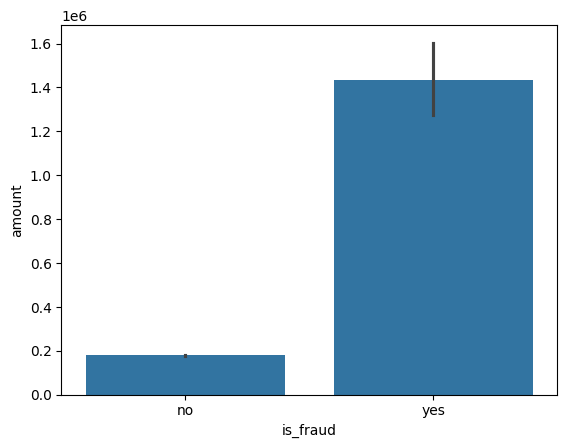

In [36]:
sns.barplot(y='amount', x='is_fraud', data=dataframe2)

Hypothesis 3: 60% of fraud transaction occours using cash-out-type method.

FALSE: The fraud transaction occours in transfer and cash-out type. However they're almost the same value.

creates a countplot using Seaborn to visualize the distribution of the 'type' variable in the subset of dataframe2 where the 'is_fraud' column has the value 'yes'. Additionally, it annotates each bar with the percentage of the total count represented by that category.

aux1 is a new DataFrame that includes only the rows from dataframe2 where the value in the 'is_fraud' column is 'yes'.

total: Calculates the total number of entries in the 'type' column for fraudulent transactions.

The for loop iterates over each bar (patch) in the countplot.

percentage: Calculates the percentage of the total count represented by each category.

x and y: Determine the coordinates for placing the annotation text. The x-coordinate is slightly to the right of the bar (p.get_x() + p.get_width() + 0.02), and the y-coordinate is in the middle of the bar (p.get_y() + p.get_height()/2).

ax.annotate(): Adds the percentage annotation to each bar at the specified coordinates.

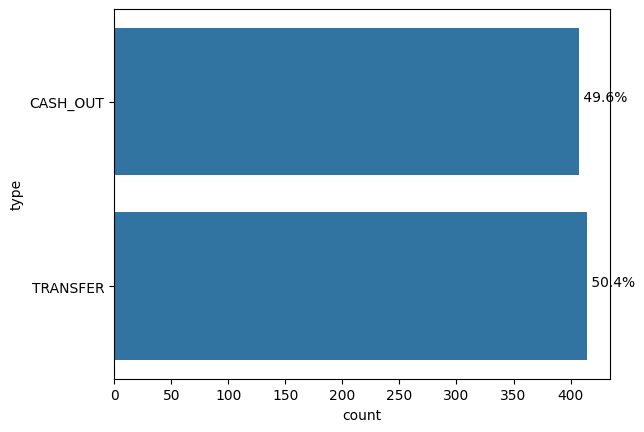

In [37]:
aux1 = dataframe2[dataframe2['is_fraud'] == 'yes']
ax = sns.countplot(y='type', data=aux1)

total = aux1['type'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

Visualisation of the complete transaction type

creates a horizontal grouped bar plot using Seaborn to compare the counts of different values in the 'type' variable for both fraudulent and non-fraudulent transactions in the DataFrame dataframe2. Additionally, it annotates each bar with the percentage of the total count represented by that category.

sns.countplot: This Seaborn function is used to create a countplot.

y='type': The variable 'type' is plotted on the y-axis.

hue='is_fraud': The 'is_fraud' variable is used to distinguish between fraudulent and non-fraudulent transactions by color-coding the bars.

data=dataframe2: The data used for plotting is the DataFrame dataframe2.

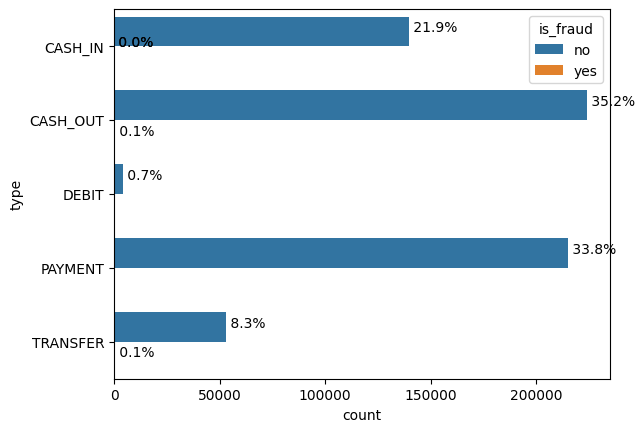

In [38]:
ax = sns.countplot(y='type', hue='is_fraud', data=dataframe2)

total = dataframe2['type'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

Hypothesis 4: Values greater than 100.000 occours using transfers-type method.

FALSE: The majority transactions occours in trasnfer-type, however transactions greater than 100.000 occour in cash-out and cash-in too.

create a horizontal bar plot to compare the average values of the 'amount' variable for different values of the 'type' variable in the DataFrame dataframe2. Additionally, it annotates each bar with the percentage of the total count represented by that category.

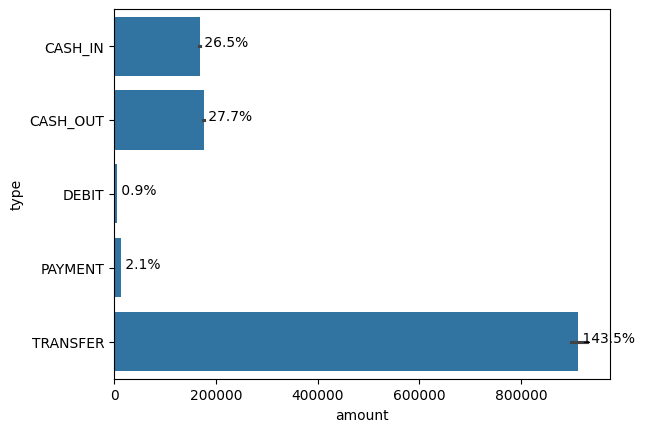

In [39]:
ax = sns.barplot(y='type', x='amount', data=dataframe2);

total = dataframe2['type'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

Hypothesis 5: Fraud transactions occours at least in 3 days.

TRUE: The values for transactions and days in fraud aren't similar.

create a scatter plot with a regression line (regression plot) to visualize the relationship between the 'step_days' variable on the x-axis and the 'amount' variable on the y-axis for the subset of dataframe2 where the 'is_fraud' column has the value 'yes'

sns.regplot: This Seaborn function is used to create a scatter plot with a regression line.

x='step_days': The variable 'step_days' is plotted on the x-axis.

y='amount': The variable 'amount' is plotted on the y-axis.

data=aux1: The data used for plotting is the subset aux1.

<Axes: xlabel='step_days', ylabel='amount'>

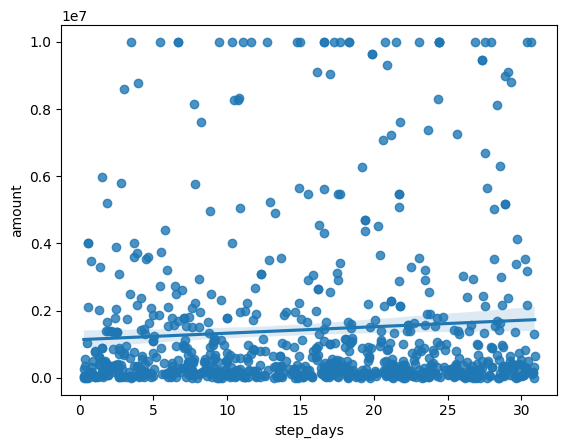

In [40]:
aux1 = dataframe2[dataframe2['is_fraud'] == 'yes']
sns.regplot(x='step_days', y='amount', data=aux1)

Multivariate Analysis

Numerical Analysis

generates a heatmap using Seaborn to visualize the correlation matrix of numerical attributes (num_attributes) in the DataFrame.

corr: Computes the correlation matrix for numerical attributes using the Pandas corr method.

mask: Creates a mask with the same shape as the correlation matrix, where the upper triangle is set to True and the lower triangle is set to False. This is done to hide redundant information, as the correlation matrix is symmetric.

sns.axes_style("white"): Sets the style of the plot to have a white background.

sns.heatmap: Creates a heatmap using Seaborn.

annot=True: Displays the numerical values in each cell of the heatmap.

mask=mask: Applies the previously defined mask to hide the upper triangle.

vmin=-1, center=0, vmax=1: Sets the range of values for the color map to represent correlations between -1 and 1.
square=True: Ensures that the heatmap has a square shape.

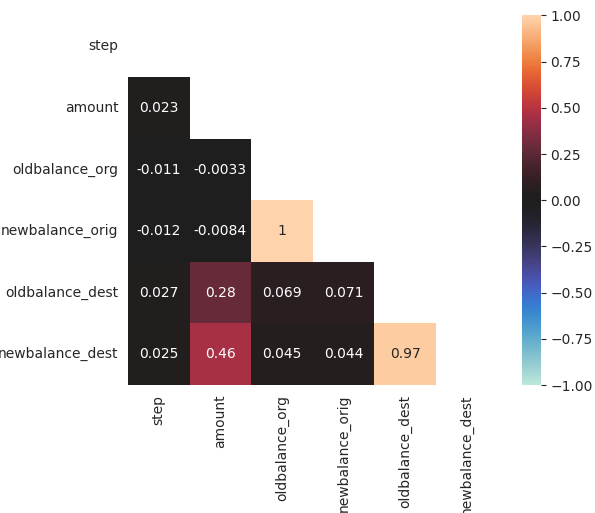

In [41]:
corr = num_attributes.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    ax = sns.heatmap(corr, annot=True, mask=mask, vmin=-1, center=0, vmax=1, square=True)

Categorical Variables

This function, calcCramerV, is designed to calculate the Cramer's V statistic for the association between two categorical variables. Cramer's V is a measure of association between two categorical variables, and it ranges from 0 to 1, where 0 indicates no association, and 1 indicates a perfect association.

Cross-tabulation and Chi-squared Test:

Code:

cm = pd.crosstab(x, y).values
n = cm.sum()
r, k = cm.shape
chi2 = stats.chi2_contingency(cm)[0]

pd.crosstab(x, y).values: Creates a contingency table (cross-tabulation) for the two categorical variables x and y.

n: Total number of observations in the contingency table.

r, k: Number of rows and columns in the contingency table.

chi2 = stats.chi2_contingency(cm)[0]: Calculates the chi-squared statistic for the contingency table.

chi2-a statistical test used to examine the differences between categorical variables from a random sample in order to judge the goodness of fit between expected and observed results.

Correction for Chi-squared Statistic:

chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))

Corrects the chi-squared statistic for the size of the contingency table

Correction for Degrees of Freedom:

kcorr = k - (k-1)**2/(n-1)

rcorr = r - (r-1)**2/(n-1)

Corrects the degrees of freedom for the size of the contingency table.

Calculate Cramer's V:

try:

    cramer_v = (chi2corr / n) / (min(kcorr-1, rcorr-1))

    # Check for NaN or negative values before taking the square root

    if np.isnan(cramer_v) or cramer_v < 0:

        cramer_v = 0.0

    else:

        cramer_v = np.sqrt(cramer_v)

except (ZeroDivisionError, RuntimeWarning):

    cramer_v = 0.0
Calculates Cramer's V using the corrected chi-squared statistic and degrees of freedom.
Handles potential cases of division by zero or runtime warnings, setting Cramer's V to 0.0 in such cases.

In [42]:
def calcCramerV(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    try:
        cramer_v = (chi2corr / n) / (min(kcorr-1, rcorr-1))
        
        # Check for NaN or negative values before taking the square root
        if np.isnan(cramer_v) or cramer_v < 0:
            cramer_v = 0.0
        else:
            cramer_v = np.sqrt(cramer_v)
    except (ZeroDivisionError, RuntimeWarning):
        cramer_v = 0.0
    
    return cramer_v


This code calculates Cramer's V for the association between all pairs of categorical variables in the DataFrame cat_attributes. The result is stored in a DataFrame named corr.

In [43]:
dict_corr = {}
columns = cat_attributes.columns.tolist()

for column in columns:
    dict_corr[column] = {}
    
    for column2 in columns:
        dict_corr[column][column2] = calcCramerV(cat_attributes[column], cat_attributes[column2])
        
corr = pd.DataFrame(dict_corr)

C:\Users\Hp\AppData\Local\Temp\ipykernel_2260\3138493454.py:13: RuntimeWarning: invalid value encountered in scalar divide
  cramer_v = (chi2corr / n) / (min(kcorr-1, rcorr-1))
C:\Users\Hp\AppData\Local\Temp\ipykernel_2260\3138493454.py:13: RuntimeWarning: invalid value encountered in scalar divide
  cramer_v = (chi2corr / n) / (min(kcorr-1, rcorr-1))
C:\Users\Hp\AppData\Local\Temp\ipykernel_2260\3138493454.py:13: RuntimeWarning: invalid value encountered in scalar divide
  cramer_v = (chi2corr / n) / (min(kcorr-1, rcorr-1))
C:\Users\Hp\AppData\Local\Temp\ipykernel_2260\3138493454.py:13: RuntimeWarning: invalid value encountered in scalar divide
  cramer_v = (chi2corr / n) / (min(kcorr-1, rcorr-1))
C:\Users\Hp\AppData\Local\Temp\ipykernel_2260\3138493454.py:13: RuntimeWarning: invalid value encountered in scalar divide
  cramer_v = (chi2corr / n) / (min(kcorr-1, rcorr-1))
C:\Users\Hp\AppData\Local\Temp\ipykernel_2260\3138493454.py:13: RuntimeWarning: invalid value encountered in scalar

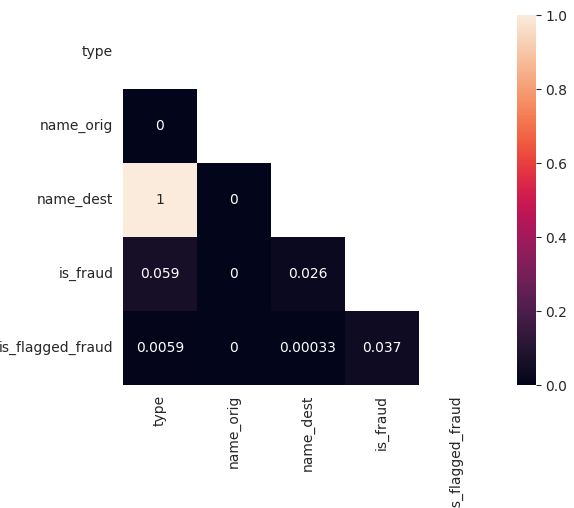

In [44]:
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    ax = sns.heatmap(corr, annot=True, mask=mask, vmin=0, vmax=1, square=True)

Data Preparation

In [45]:
dataframe3=dataframe2.copy()

Spliting into Train, Valid and Test

In [46]:
X = dataframe3.drop(columns=['is_fraud', 'is_flagged_fraud', 'name_orig', 'name_dest', 
                      'step_weeks', 'step_days'], axis=1)
y = dataframe3['is_fraud'].map({'yes': 1, 'no': 0})

In [47]:
X

,step,type,amount,oldbalance_org,newbalance_orig,oldbalance_dest,newbalance_dest,diff_new_old_balance,diff_new_old_dest
0,283,CASH_IN,210329.84,3778062.79,3988392.64,1519266.60,1308936.76,210329.85,-210329.84
1,132,CASH_OUT,215489.19,21518.00,0.00,6345756.55,6794954.89,-21518.00,449198.34
2,355,DEBIT,4431.05,20674.00,16242.95,80876.56,85307.61,-4431.05,4431.05
3,135,CASH_OUT,214026.20,46909.73,0.00,13467450.36,13681476.56,-46909.73,214026.20
4,381,CASH_OUT,8858.45,0.00,0.00,1667180.58,1676039.03,0.00,8858.45
...,...,...,...,...,...,...,...,...,...
636257,351,CASH_OUT,28761.10,0.00,0.00,328534.52,357295.62,0.00,28761.10
636258,184,CASH_OUT,167820.71,62265.00,0.00,106429.48,274250.18,-62265.00,167820.70
636259,35,PAYMENT,8898.12,30808.00,21909.88,0.00,0.00,-8898.12,0.00
636260,277,CASH_OUT,176147.90,83669.00,0.00,0.00,176147.90,-83669.00,176147.90


In [48]:
y

0         0
1         0
2         0
3         0
4         0
         ..
636257    0
636258    0
636259    0
636260    0
636261    0
Name: is_fraud, Length: 636262, dtype: int64

stratify=y: Ensures that the class distribution of the target variable is preserved in the train-test split. This is important, especially when dealing with imbalanced datasets.

The entire dataset is split into train and test where the training dataset is called temp here and the testing dataset is called test here. Further the temp dataset is divided into training and valid.

So, basically, Dataset->temp and test and temp->training and valid

Also, X_params is just a copy of X_temp(which is a combination of training and valid data)

In [49]:
# spliting into temp and test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=.2, stratify=y, random_state=42)

In [50]:
X_temp

,step,type,amount,oldbalance_org,newbalance_orig,oldbalance_dest,newbalance_dest,diff_new_old_balance,diff_new_old_dest
334727,19,PAYMENT,9103.84,26544.00,17440.16,0.00,0.00,-9103.84,0.00
501597,400,CASH_OUT,161101.24,0.00,0.00,761206.09,922307.33,0.00,161101.24
354938,15,PAYMENT,12339.85,50839.00,38499.15,0.00,0.00,-12339.85,0.00
95477,15,CASH_OUT,160574.60,21843.00,0.00,107548.00,87381.51,-21843.00,-20166.49
218554,134,CASH_OUT,64693.16,47062.00,0.00,180153.08,244846.25,-47062.00,64693.17
...,...,...,...,...,...,...,...,...,...
511925,393,CASH_OUT,92042.43,38193.00,0.00,0.00,92042.43,-38193.00,92042.43
307806,349,CASH_IN,185220.18,19541.00,204761.18,658902.17,473681.99,185220.18,-185220.18
33509,372,PAYMENT,7401.84,0.00,0.00,0.00,0.00,0.00,0.00
440700,354,CASH_OUT,106833.55,351956.00,245122.45,1433665.67,1540499.22,-106833.55,106833.55


In [51]:
X_test

,step,type,amount,oldbalance_org,newbalance_orig,oldbalance_dest,newbalance_dest,diff_new_old_balance,diff_new_old_dest
578630,94,TRANSFER,672901.28,0.00,0.00,8881502.26,10664836.01,0.00,1783333.75
248692,234,CASH_OUT,42319.66,0.00,0.00,273167.66,315487.32,0.00,42319.66
43980,231,DEBIT,5635.52,133346.00,127710.48,45858.49,51494.02,-5635.52,5635.53
331603,358,CASH_IN,156974.98,425464.73,582439.71,1033044.87,876069.89,156974.98,-156974.98
123136,33,CASH_IN,321256.73,10501.00,331757.73,87655.83,0.00,321256.73,-87655.83
...,...,...,...,...,...,...,...,...,...
148808,299,TRANSFER,3766148.37,591916.03,0.00,5868394.99,9634543.36,-591916.03,3766148.37
366823,187,CASH_OUT,73952.83,21340.00,0.00,1782007.50,1855960.33,-21340.00,73952.83
404135,405,PAYMENT,397.07,248799.00,248401.93,0.00,0.00,-397.07,0.00
52628,13,CASH_IN,86888.01,26859.00,113747.01,3087808.51,3000920.50,86888.01,-86888.01


In [52]:
y_temp

334727    0
501597    0
354938    0
95477     0
218554    0
         ..
511925    0
307806    0
33509     0
440700    0
403078    0
Name: is_fraud, Length: 509009, dtype: int64

In [53]:
y_test

578630    0
248692    0
43980     0
331603    0
123136    0
         ..
148808    0
366823    0
404135    0
52628     0
151127    0
Name: is_fraud, Length: 127253, dtype: int64

In [54]:
# spliting into train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=.2, stratify=y_temp,random_state=42)

In [55]:
X_train

,step,type,amount,oldbalance_org,newbalance_orig,oldbalance_dest,newbalance_dest,diff_new_old_balance,diff_new_old_dest
163061,204,CASH_OUT,168910.78,40055.00,0.00,0.00,168910.78,-40055.00,168910.78
572476,47,PAYMENT,703.16,86730.91,86027.76,0.00,0.00,-703.15,0.00
217088,259,TRANSFER,538928.49,31522.98,0.00,4462600.66,5001529.15,-31522.98,538928.49
100570,17,CASH_OUT,25969.21,187481.00,161511.79,0.00,25969.21,-25969.21,25969.21
253547,252,PAYMENT,15184.13,75101.00,59916.87,0.00,0.00,-15184.13,0.00
...,...,...,...,...,...,...,...,...,...
411243,162,CASH_OUT,404434.31,20948.00,0.00,0.00,404434.31,-20948.00,404434.31
600382,278,CASH_OUT,174953.72,217.00,0.00,198107.53,373061.24,-217.00,174953.71
243273,133,PAYMENT,33596.49,0.00,0.00,0.00,0.00,0.00,0.00
410598,17,PAYMENT,3793.50,0.00,0.00,0.00,0.00,0.00,0.00


In [56]:
X_valid

,step,type,amount,oldbalance_org,newbalance_orig,oldbalance_dest,newbalance_dest,diff_new_old_balance,diff_new_old_dest
153857,225,PAYMENT,22188.19,396892.0,374703.81,0.00,0.00,-22188.19,0.00
266302,331,TRANSFER,155996.66,0.0,0.00,1881990.98,2372103.71,0.00,490112.73
237544,185,CASH_IN,207356.26,20906.0,228262.26,0.00,0.00,207356.26,0.00
70549,165,CASH_OUT,156541.96,51126.0,0.00,361899.29,518441.25,-51126.00,156541.96
369002,681,PAYMENT,13380.60,85338.0,71957.40,0.00,0.00,-13380.60,0.00
...,...,...,...,...,...,...,...,...,...
198381,399,PAYMENT,11796.93,185809.0,174012.07,0.00,0.00,-11796.93,0.00
100265,352,CASH_OUT,43366.72,0.0,0.00,897148.15,940514.87,0.00,43366.72
40155,356,PAYMENT,3560.23,46.0,0.00,0.00,0.00,-46.00,0.00
293934,379,CASH_OUT,115633.17,103964.0,0.00,570327.23,685960.41,-103964.00,115633.18


In [57]:
y_train

163061    0
572476    0
217088    0
100570    0
253547    0
         ..
411243    0
600382    0
243273    0
410598    0
19200     0
Name: is_fraud, Length: 407207, dtype: int64

In [58]:
y_valid

153857    0
266302    0
237544    0
70549     0
369002    0
         ..
198381    0
100265    0
40155     0
293934    0
251636    0
Name: is_fraud, Length: 101802, dtype: int64

One Hot Encoder

ohe = OneHotEncoder(cols=['type'], use_cat_names=True): Creates an instance of the OneHotEncoder class. It specifies that the 'type' column should be one-hot encoded, and use_cat_names=True indicates to use category names as column names in the resulting DataFrame.

X_train = ohe.fit_transform(X_train): Fits the one-hot encoder on the training data (X_train) and transforms it.

X_valid = ohe.transform(X_valid): Transforms the validation data (X_valid) using the same encoder fitted on the training data. This ensures consistency in the encoding.

X_temp = ohe.fit_transform(X_temp): Fits the encoder on the combined training and validation data (X_temp) and transforms it.

X_test = ohe.transform(X_test): Transforms the test data (X_test) using the same encoder fitted on the combined training and validation data. This ensures consistency in the encoding.

In [59]:
ohe = OneHotEncoder(cols=['type'], use_cat_names=True)

X_train = ohe.fit_transform(X_train)
X_valid = ohe.transform(X_valid)

X_temp = ohe.fit_transform(X_temp)
X_test = ohe.transform(X_test)

In [60]:
X_train

,step,type_CASH_OUT,type_PAYMENT,type_TRANSFER,type_CASH_IN,type_DEBIT,amount,oldbalance_org,newbalance_orig,oldbalance_dest,newbalance_dest,diff_new_old_balance,diff_new_old_dest
163061,204,1,0,0,0,0,168910.78,40055.00,0.00,0.00,168910.78,-40055.00,168910.78
572476,47,0,1,0,0,0,703.16,86730.91,86027.76,0.00,0.00,-703.15,0.00
217088,259,0,0,1,0,0,538928.49,31522.98,0.00,4462600.66,5001529.15,-31522.98,538928.49
100570,17,1,0,0,0,0,25969.21,187481.00,161511.79,0.00,25969.21,-25969.21,25969.21
253547,252,0,1,0,0,0,15184.13,75101.00,59916.87,0.00,0.00,-15184.13,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
411243,162,1,0,0,0,0,404434.31,20948.00,0.00,0.00,404434.31,-20948.00,404434.31
600382,278,1,0,0,0,0,174953.72,217.00,0.00,198107.53,373061.24,-217.00,174953.71
243273,133,0,1,0,0,0,33596.49,0.00,0.00,0.00,0.00,0.00,0.00
410598,17,0,1,0,0,0,3793.50,0.00,0.00,0.00,0.00,0.00,0.00


In [61]:
X_test

,step,type_PAYMENT,type_CASH_OUT,type_CASH_IN,type_TRANSFER,type_DEBIT,amount,oldbalance_org,newbalance_orig,oldbalance_dest,newbalance_dest,diff_new_old_balance,diff_new_old_dest
578630,94,0,0,0,1,0,672901.28,0.00,0.00,8881502.26,10664836.01,0.00,1783333.75
248692,234,0,1,0,0,0,42319.66,0.00,0.00,273167.66,315487.32,0.00,42319.66
43980,231,0,0,0,0,1,5635.52,133346.00,127710.48,45858.49,51494.02,-5635.52,5635.53
331603,358,0,0,1,0,0,156974.98,425464.73,582439.71,1033044.87,876069.89,156974.98,-156974.98
123136,33,0,0,1,0,0,321256.73,10501.00,331757.73,87655.83,0.00,321256.73,-87655.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...
148808,299,0,0,0,1,0,3766148.37,591916.03,0.00,5868394.99,9634543.36,-591916.03,3766148.37
366823,187,0,1,0,0,0,73952.83,21340.00,0.00,1782007.50,1855960.33,-21340.00,73952.83
404135,405,1,0,0,0,0,397.07,248799.00,248401.93,0.00,0.00,-397.07,0.00
52628,13,0,0,1,0,0,86888.01,26859.00,113747.01,3087808.51,3000920.50,86888.01,-86888.01


In [62]:
X_valid

,step,type_CASH_OUT,type_PAYMENT,type_TRANSFER,type_CASH_IN,type_DEBIT,amount,oldbalance_org,newbalance_orig,oldbalance_dest,newbalance_dest,diff_new_old_balance,diff_new_old_dest
153857,225,0,1,0,0,0,22188.19,396892.0,374703.81,0.00,0.00,-22188.19,0.00
266302,331,0,0,1,0,0,155996.66,0.0,0.00,1881990.98,2372103.71,0.00,490112.73
237544,185,0,0,0,1,0,207356.26,20906.0,228262.26,0.00,0.00,207356.26,0.00
70549,165,1,0,0,0,0,156541.96,51126.0,0.00,361899.29,518441.25,-51126.00,156541.96
369002,681,0,1,0,0,0,13380.60,85338.0,71957.40,0.00,0.00,-13380.60,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
198381,399,0,1,0,0,0,11796.93,185809.0,174012.07,0.00,0.00,-11796.93,0.00
100265,352,1,0,0,0,0,43366.72,0.0,0.00,897148.15,940514.87,0.00,43366.72
40155,356,0,1,0,0,0,3560.23,46.0,0.00,0.00,0.00,-46.00,0.00
293934,379,1,0,0,0,0,115633.17,103964.0,0.00,570327.23,685960.41,-103964.00,115633.18


In [63]:
X_temp

,step,type_PAYMENT,type_CASH_OUT,type_CASH_IN,type_TRANSFER,type_DEBIT,amount,oldbalance_org,newbalance_orig,oldbalance_dest,newbalance_dest,diff_new_old_balance,diff_new_old_dest
334727,19,1,0,0,0,0,9103.84,26544.00,17440.16,0.00,0.00,-9103.84,0.00
501597,400,0,1,0,0,0,161101.24,0.00,0.00,761206.09,922307.33,0.00,161101.24
354938,15,1,0,0,0,0,12339.85,50839.00,38499.15,0.00,0.00,-12339.85,0.00
95477,15,0,1,0,0,0,160574.60,21843.00,0.00,107548.00,87381.51,-21843.00,-20166.49
218554,134,0,1,0,0,0,64693.16,47062.00,0.00,180153.08,244846.25,-47062.00,64693.17
...,...,...,...,...,...,...,...,...,...,...,...,...,...
511925,393,0,1,0,0,0,92042.43,38193.00,0.00,0.00,92042.43,-38193.00,92042.43
307806,349,0,0,1,0,0,185220.18,19541.00,204761.18,658902.17,473681.99,185220.18,-185220.18
33509,372,1,0,0,0,0,7401.84,0.00,0.00,0.00,0.00,0.00,0.00
440700,354,0,1,0,0,0,106833.55,351956.00,245122.45,1433665.67,1540499.22,-106833.55,106833.55


Rescaling

In [64]:
num_columns = ['amount', 'oldbalance_org', 'newbalance_orig', 'oldbalance_dest', 'newbalance_dest',
               'diff_new_old_balance', 'diff_new_old_dest']
mm = MinMaxScaler()
X_params = X_temp.copy()

X_train[num_columns] = mm.fit_transform(X_train[num_columns])
X_valid[num_columns] = mm.transform(X_valid[num_columns])

X_params[num_columns] = mm.fit_transform(X_temp[num_columns])
X_test[num_columns] = mm.transform(X_test[num_columns])

Feature Selection

Boruta

In [65]:
X_params

,step,type_PAYMENT,type_CASH_OUT,type_CASH_IN,type_TRANSFER,type_DEBIT,amount,oldbalance_org,newbalance_orig,oldbalance_dest,newbalance_dest,diff_new_old_balance,diff_new_old_dest
334727,19,1,0,0,0,0,0.000159,0.000699,0.000457,0.000000,0.000000,0.878004,0.069787
501597,400,0,1,0,0,0,0.002815,0.000000,0.000000,0.002143,0.002595,0.878805,0.071597
354938,15,1,0,0,0,0,0.000216,0.001340,0.001009,0.000000,0.000000,0.877720,0.069787
95477,15,0,1,0,0,0,0.002806,0.000576,0.000000,0.000303,0.000246,0.876885,0.069561
218554,134,0,1,0,0,0,0.001130,0.001240,0.000000,0.000507,0.000689,0.874669,0.070514
...,...,...,...,...,...,...,...,...,...,...,...,...,...
511925,393,0,1,0,0,0,0.001608,0.001006,0.000000,0.000000,0.000259,0.875448,0.070821
307806,349,0,0,1,0,0,0.003236,0.000515,0.005365,0.001855,0.001333,0.895082,0.067707
33509,372,1,0,0,0,0,0.000129,0.000000,0.000000,0.000000,0.000000,0.878805,0.069787
440700,354,0,1,0,0,0,0.001867,0.009274,0.006422,0.004036,0.004335,0.869416,0.070987


In [66]:
X_params.values

array([[1.90000000e+01, 1.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 8.78004496e-01, 6.97873057e-02],
       [4.00000000e+02, 0.00000000e+00, 1.00000000e+00, ...,
        2.59526725e-03, 8.78804546e-01, 7.15965276e-02],
       [1.50000000e+01, 1.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 8.77720114e-01, 6.97873057e-02],
       ...,
       [3.72000000e+02, 1.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 8.78804546e-01, 6.97873057e-02],
       [3.54000000e+02, 0.00000000e+00, 1.00000000e+00, ...,
        4.33478846e-03, 8.69415965e-01, 7.09870829e-02],
       [3.22000000e+02, 0.00000000e+00, 0.00000000e+00, ...,
        2.99733426e-04, 8.93019761e-01, 6.79707274e-02]])

In [67]:
X_params.values.shape

(509009, 13)

In [68]:
y_temp

334727    0
501597    0
354938    0
95477     0
218554    0
         ..
511925    0
307806    0
33509     0
440700    0
403078    0
Name: is_fraud, Length: 509009, dtype: int64

In [69]:
y_temp.values.ravel()

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [70]:
X_boruta = X_params.values
y_boruta = y_temp.values.ravel()

In [71]:
X_boruta

array([[1.90000000e+01, 1.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 8.78004496e-01, 6.97873057e-02],
       [4.00000000e+02, 0.00000000e+00, 1.00000000e+00, ...,
        2.59526725e-03, 8.78804546e-01, 7.15965276e-02],
       [1.50000000e+01, 1.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 8.77720114e-01, 6.97873057e-02],
       ...,
       [3.72000000e+02, 1.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 8.78804546e-01, 6.97873057e-02],
       [3.54000000e+02, 0.00000000e+00, 1.00000000e+00, ...,
        4.33478846e-03, 8.69415965e-01, 7.09870829e-02],
       [3.22000000e+02, 0.00000000e+00, 0.00000000e+00, ...,
        2.99733426e-04, 8.93019761e-01, 6.79707274e-02]])

In [72]:
X_boruta.shape

(509009, 13)

In [73]:
y_boruta

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [74]:
y_boruta.shape

(509009,)

BorutaPy: This is the main class from the Boruta library for feature selection.

RandomForestClassifier(): This is the classifier used by Boruta to evaluate feature importance. In this case, you're using a Random Forest classifier, which is a popular choice for feature selection because it can capture non-linear relationships and interactions between features.

n_estimators='auto': This parameter sets the number of trees in the Random Forest. The use of 'auto' means that the number of trees will be determined automatically based on the size of the dataset. Alternatively, you can specify a fixed number if you have a preference.

After initializing the BorutaPy object, you can proceed to fit it on your data and obtain the selected features

In [75]:
borutaa=BorutaPy(RandomForestClassifier(), n_estimators='auto')

In [76]:
# Reassigning np.int to np.int64
np.int = np.int32

# Reassigning np.float to np.float64
np.float = np.float64

# Reassigning np.bool to np.bool_
np.bool = np.bool_

In [77]:
#borutaa.fit(X_boruta, y_boruta)

Best Features

In [78]:
# cols_selected_boruta = boruta.support_.tolist()
# columns_selected = X_params.loc[:, cols_selected_boruta].columns.tolist()
# columns_selected
# ['step',
#  'amount',
#  'oldbalance_org',
#  'newbalance_orig',
#  'oldbalance_dest',
#  'newbalance_dest',
#  'diff_new_old_balance',
#  'diff_new_old_destiny',
#  'type_TRANSFER']

In [79]:
final_columns_selected = ['step', 'oldbalance_org', 
                          'newbalance_orig', 'newbalance_dest', 
                          'diff_new_old_balance', 'diff_new_old_dest', 
                          'type_TRANSFER']

Machine Learning Modeling

 created subsets of your original datasets (X_train, X_valid, X_temp, X_test, and X_params) by selecting only the final columns that were identified as relevant by Boruta. 

In [80]:
X_train_cs = X_train[final_columns_selected]
X_valid_cs = X_valid[final_columns_selected]

X_temp_cs = X_temp[final_columns_selected]
X_test_cs = X_test[final_columns_selected]

X_params_cs = X_params[final_columns_selected]

In [81]:
X_params_cs

,step,oldbalance_org,newbalance_orig,newbalance_dest,diff_new_old_balance,diff_new_old_dest,type_TRANSFER
334727,19,0.000699,0.000457,0.000000,0.878004,0.069787,0
501597,400,0.000000,0.000000,0.002595,0.878805,0.071597,0
354938,15,0.001340,0.001009,0.000000,0.877720,0.069787,0
95477,15,0.000576,0.000000,0.000246,0.876885,0.069561,0
218554,134,0.001240,0.000000,0.000689,0.874669,0.070514,0
...,...,...,...,...,...,...,...
511925,393,0.001006,0.000000,0.000259,0.875448,0.070821,0
307806,349,0.000515,0.005365,0.001333,0.895082,0.067707,0
33509,372,0.000000,0.000000,0.000000,0.878805,0.069787,0
440700,354,0.009274,0.006422,0.004335,0.869416,0.070987,0


Baseline

used a DummyClassifier to fit a baseline model on your training data (X_train_cs, y_train) and then made predictions on your validation data (X_valid_cs). The DummyClassifier is a simple classifier that makes predictions using simple rules

In [82]:
dummy = DummyClassifier()
dummy.fit(X_train_cs, y_train)

y_pred = dummy.predict(X_valid_cs)

In [83]:
y_valid

153857    0
266302    0
237544    0
70549     0
369002    0
         ..
198381    0
100265    0
40155     0
293934    0
251636    0
Name: is_fraud, Length: 101802, dtype: int64

In [84]:
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [85]:
dummy_results = ml_scores('dummy', y_valid, y_pred)
dummy_results

c:\Users\Hp\Documents\Minor_Project\minor_project_env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Balanced Accuracy,Precision,Recall,F1,Kappa
dummy,0.5,0.0,0.0,0.0,0.0


Classification Report

The classification_report function in scikit-learn provides a text report showing the main classification metrics (precision, recall, F1-score, and support) for each class. It's a useful summary to evaluate the performance of a classifier.

In [86]:
print(classification_report(y_valid, y_pred))

c:\Users\Hp\Documents\Minor_Project\minor_project_env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Hp\Documents\Minor_Project\minor_project_env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    101671
           1       0.00      0.00      0.00       131

    accuracy                           1.00    101802
   macro avg       0.50      0.50      0.50    101802
weighted avg       1.00      1.00      1.00    101802



c:\Users\Hp\Documents\Minor_Project\minor_project_env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Cross Validation

In [87]:
def ml_cv_results(model_name, model, x, y, verbose=1):
    
    '''initial'''
    balanced_accuracies = []
    precisions = []
    recalls = []
    f1s = []
    kappas = []
    
    mm = MinMaxScaler()
    
    x_ = x.to_numpy()
    y_ = y.to_numpy()
    
    count = 0
    
    '''cross-validation'''
    skf = StratifiedKFold(n_splits=5, shuffle=True)
    
    for index_train, index_test in skf.split(x_, y_):
        ## Showing the Fold
        if verbose > 0:
            count += 1
            print('Fold K=%i' % (count))
    
        ## selecting train and test
        x_train, x_test = x.iloc[index_train], x.iloc[index_test]
        y_train, y_test = y.iloc[index_train], y.iloc[index_test]
        
        ## applying the scale
        x_train = mm.fit_transform(x_train)
        x_test = mm.transform(x_test)
    
        ## training the model
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)

        ## saving the metrics
        balanced_accuracies.append(balanced_accuracy_score(y_test, y_pred))
        precisions.append(precision_score(y_test, y_pred))
        recalls.append(recall_score(y_test, y_pred))
        f1s.append(f1_score(y_test, y_pred))
        kappas.append(cohen_kappa_score(y_test, y_pred))
        
        
    '''results'''    
    accuracy_mean, accuracy_std = np.round(np.mean(balanced_accuracies), 3), np.round(np.std(balanced_accuracies), 3)
    precision_mean, precision_std = np.round(np.mean(precisions), 3), np.round(np.std(precisions), 3)
    recall_mean, recall_std = np.round(np.mean(recalls), 3), np.round(np.std(recalls), 3)
    f1_mean, f1_std = np.round(np.mean(f1s), 3), np.round(np.std(f1s), 3)
    kappa_mean, kappa_std = np.round(np.mean(kappas), 3), np.round(np.std(kappas), 3)
    
    ## saving the results in a dataframe
    return pd.DataFrame({"Balanced Accuracy": "{} +/- {}".format(accuracy_mean, accuracy_std),
                        "Precision": "{} +/- {}".format(precision_mean, precision_std),
                        "Recall": "{} +/- {}".format(recall_mean, recall_std),
                        "F1": "{} +/- {}".format(f1_mean, f1_std),
                        "Kappa": "{} +/- {}".format(kappa_mean, kappa_std)},
                       index=[model_name])

In [88]:
dummy_cv = ml_cv_results('Dummy', DummyClassifier(), X_temp, y_temp)
dummy_cv

Fold K=1


c:\Users\Hp\Documents\Minor_Project\minor_project_env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold K=2


c:\Users\Hp\Documents\Minor_Project\minor_project_env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold K=3


c:\Users\Hp\Documents\Minor_Project\minor_project_env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold K=4


c:\Users\Hp\Documents\Minor_Project\minor_project_env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold K=5


c:\Users\Hp\Documents\Minor_Project\minor_project_env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Balanced Accuracy,Precision,Recall,F1,Kappa
Dummy,0.5 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0


Logistic Regression

In [89]:
lg = LogisticRegression()
lg.fit(X_train_cs, y_train)

y_pred = lg.predict(X_valid_cs)

c:\Users\Hp\Documents\Minor_Project\minor_project_env\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [90]:
lg_results = ml_scores('Logistic Regression', y_valid, y_pred)
lg_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
Logistic Regression,0.561,1.0,0.122,0.218,0.217


Classification Report

In [91]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    101671
           1       1.00      0.12      0.22       131

    accuracy                           1.00    101802
   macro avg       1.00      0.56      0.61    101802
weighted avg       1.00      1.00      1.00    101802



Cross Validation

In [92]:
lg_cv = ml_cv_results('Logistic Regression',
                      LogisticRegression(), 
                      X_temp_cs, y_temp)
lg_cv

Fold K=1


Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1,Kappa
Logistic Regression,0.565 +/- 0.02,1.0 +/- 0.0,0.129 +/- 0.04,0.227 +/- 0.063,0.227 +/- 0.063


K Nearest Neighbors

In [93]:
knn = KNeighborsClassifier()
knn.fit(X_train_cs, y_train)

y_pred = knn.predict(X_valid_cs)

In [94]:
knn_results = ml_scores('K Nearest Neighbors', y_valid, y_pred)
knn_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
K Nearest Neighbors,0.588,1.0,0.176,0.299,0.298


Classification Report

In [95]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    101671
           1       1.00      0.18      0.30       131

    accuracy                           1.00    101802
   macro avg       1.00      0.59      0.65    101802
weighted avg       1.00      1.00      1.00    101802



Cross Validation

In [96]:
knn_cv = ml_cv_results('K Nearest Neighbors', KNeighborsClassifier(), 
                       X_temp_cs, y_temp)
knn_cv

Fold K=1


Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1,Kappa
K Nearest Neighbors,0.703 +/- 0.018,0.943 +/- 0.064,0.406 +/- 0.036,0.568 +/- 0.046,0.567 +/- 0.046


Support Vector Machine

In [97]:
svm = SVC()
svm.fit(X_train_cs, y_train)

y_pred = svm.predict(X_valid_cs)

In [98]:
svm_results = ml_scores('SVM', y_valid, y_pred)
svm_results

c:\Users\Hp\Documents\Minor_Project\minor_project_env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Balanced Accuracy,Precision,Recall,F1,Kappa
SVM,0.5,0.0,0.0,0.0,0.0


Classification Report

In [99]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    101671
           1       0.00      0.00      0.00       131

    accuracy                           1.00    101802
   macro avg       0.50      0.50      0.50    101802
weighted avg       1.00      1.00      1.00    101802



c:\Users\Hp\Documents\Minor_Project\minor_project_env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Hp\Documents\Minor_Project\minor_project_env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Hp\Documents\Minor_Project\minor_project_env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Cross Validation

In [100]:
svm_cv = ml_cv_results('SVM', SVC(), X_temp_cs, y_temp)
svm_cv

Fold K=1


Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1,Kappa
SVM,0.597 +/- 0.024,1.0 +/- 0.0,0.193 +/- 0.049,0.321 +/- 0.067,0.321 +/- 0.067


Random Forest

In [101]:
rf = RandomForestClassifier(class_weight='balanced')
rf.fit(X_train_cs, y_train)

y_pred = rf.predict(X_valid_cs)

In [102]:
rf_results = ml_scores('Random Forest', y_valid, y_pred)
rf_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
Random Forest,0.851,1.0,0.702,0.825,0.825


Classification Report

In [103]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    101671
           1       1.00      0.70      0.83       131

    accuracy                           1.00    101802
   macro avg       1.00      0.85      0.91    101802
weighted avg       1.00      1.00      1.00    101802



Cross Validation

In [104]:
rf_cv = ml_cv_results('Random Forest', 
                      RandomForestClassifier(), 
                      X_temp_cs, y_temp)
rf_cv

Fold K=1


Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1,Kappa
Random Forest,0.865 +/- 0.025,0.97 +/- 0.009,0.729 +/- 0.05,0.831 +/- 0.031,0.831 +/- 0.031


XGBoost

In [105]:
xgb = XGBClassifier()
xgb.fit(X_train_cs, y_train)

y_pred = xgb.predict(X_valid_cs)

In [106]:
xgb_results = ml_scores('XGBoost', y_valid, y_pred)
xgb_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
XGBoost,0.882,0.962,0.763,0.851,0.851


Classification Report

In [107]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    101671
           1       0.96      0.76      0.85       131

    accuracy                           1.00    101802
   macro avg       0.98      0.88      0.93    101802
weighted avg       1.00      1.00      1.00    101802



Cross Validation

In [108]:
xgb_cv = ml_cv_results('XGBoost', XGBClassifier(),
                       X_temp_cs, y_temp)
xgb_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1,Kappa
XGBoost,0.885 +/- 0.027,0.945 +/- 0.017,0.77 +/- 0.053,0.847 +/- 0.029,0.847 +/- 0.029


LightGBM

In [109]:
lightgbm = LGBMClassifier()
lightgbm.fit(X_train_cs, y_train)

y_pred = lightgbm.predict(X_valid_cs)

[LightGBM] [Info] Number of positive: 526, number of negative: 406681
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014854 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 407207, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001292 -> initscore=-6.650483
[LightGBM] [Info] Start training from score -6.650483


In [110]:
lightgbm_results = ml_scores('LightGBM', y_valid, y_pred)
lightgbm_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
LightGBM,0.618,0.164,0.237,0.194,0.193


Classification Report

In [111]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    101671
           1       0.16      0.24      0.19       131

    accuracy                           1.00    101802
   macro avg       0.58      0.62      0.60    101802
weighted avg       1.00      1.00      1.00    101802



Cross Validation

In [112]:
lightgbm_cv = ml_cv_results('LightGDM', LGBMClassifier(), 
                            X_temp_cs, y_temp)
lightgbm_cv

Fold K=1


[LightGBM] [Info] Number of positive: 526, number of negative: 406681
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012596 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 407207, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001292 -> initscore=-6.650483
[LightGBM] [Info] Start training from score -6.650483
Fold K=2
[LightGBM] [Info] Number of positive: 526, number of negative: 406681
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 407207, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001292 -> initscore=-6.6

,Balanced Accuracy,Precision,Recall,F1,Kappa
LightGDM,0.702 +/- 0.054,0.266 +/- 0.117,0.407 +/- 0.106,0.311 +/- 0.124,0.309 +/- 0.125


Comparing Model's Performance

Single Performance

In [113]:
modeling_performance = pd.concat([dummy_results, lg_results, knn_results, 
                                  rf_results, xgb_results, lightgbm_results,
                                 svm_results])
modeling_performance.sort_values(by="F1", ascending=True)

,Balanced Accuracy,Precision,Recall,F1,Kappa
dummy,0.500,0.000,0.000,0.000,0.000
SVM,0.500,0.000,0.000,0.000,0.000
LightGBM,0.618,0.164,0.237,0.194,0.193
Logistic Regression,0.561,1.000,0.122,0.218,0.217
K Nearest Neighbors,0.588,1.000,0.176,0.299,0.298
Random Forest,0.851,1.000,0.702,0.825,0.825
XGBoost,0.882,0.962,0.763,0.851,0.851


Cross Validation Performance

In [114]:
modeling_performance_cv = pd.concat([dummy_cv, lg_cv, knn_cv, rf_cv, 
                                     xgb_cv, lightgbm_cv, svm_cv])

modeling_performance_cv.sort_values(by="F1", ascending=True)

,Balanced Accuracy,Precision,Recall,F1,Kappa
Dummy,0.5 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0
Logistic Regression,0.565 +/- 0.02,1.0 +/- 0.0,0.129 +/- 0.04,0.227 +/- 0.063,0.227 +/- 0.063
LightGDM,0.702 +/- 0.054,0.266 +/- 0.117,0.407 +/- 0.106,0.311 +/- 0.124,0.309 +/- 0.125
SVM,0.597 +/- 0.024,1.0 +/- 0.0,0.193 +/- 0.049,0.321 +/- 0.067,0.321 +/- 0.067
K Nearest Neighbors,0.703 +/- 0.018,0.943 +/- 0.064,0.406 +/- 0.036,0.568 +/- 0.046,0.567 +/- 0.046
Random Forest,0.865 +/- 0.025,0.97 +/- 0.009,0.729 +/- 0.05,0.831 +/- 0.031,0.831 +/- 0.031
XGBoost,0.885 +/- 0.027,0.945 +/- 0.017,0.77 +/- 0.053,0.847 +/- 0.029,0.847 +/- 0.029


Hyperparameter Fine Tuning

Scorer Definition:

f1 = make_scorer(f1_score): This line creates a scorer for the F1 score using make_scorer from scikit-learn. This scorer will be used as the evaluation metric during hyperparameter tuning.

Hyperparameter Grid:

params: This dictionary defines the hyperparameters and their possible values that will be explored during the grid search.

GridSearchCV Setup:

gs = GridSearchCV(...): This line creates a GridSearchCV object with the following parameters:

XGBClassifier(): The base model to be tuned.

param_grid=params: The hyperparameter grid.

scoring=f1: The F1 score will be used as the evaluation metric.

cv=StratifiedKFold(n_splits=5): Stratified k-fold cross-validation with 5 folds.

Grid Search Execution:

gs.fit(X_params_cs, y_temp): This line executes the grid search by fitting the XGBoost model on the specified data (X_params_cs and y_temp).

Best Hyperparameters and Score Retrieval:

best_params = gs.best_params_: Retrieves the best hyperparameters found by the grid search.

gs.best_score_: Retrieves the corresponding best F1 score.

Print Results:

The final two print statements display the best hyperparameters and the corresponding best F1 score.

This code helps you find the optimal hyperparameters for your XGBoost model based on F1 score using a grid search with cross-validation.

In [115]:
f1 = make_scorer(f1_score)

In [116]:
params = {
    'booster': ['gbtree', 'gblinear', 'dart'],
    'eta': [0.3, 0.1, 0.01],
    'scale_pos_weight': [1, 774, 508, 99]
}

In [117]:
# gs = GridSearchCV(XGBClassifier(), 
#                   param_grid=params, 
#                   scoring=f1, 
#                   cv=StratifiedKFold(n_splits=5))

# gs.fit(X_params_cs, y_temp)

In [118]:
# GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
#              estimator=XGBClassifier(base_score=None, booster=None,
#                                      colsample_bylevel=None,
#                                      colsample_bynode=None,
#                                      colsample_bytree=None, gamma=None,
#                                      gpu_id=None, importance_type='gain',
#                                      interaction_constraints=None,
#                                      learning_rate=None, max_delta_step=None,
#                                      max_depth=None, min_child_weight=None,
#                                      mis...constraints=None,
#                                      n_estimators=100, n_jobs=None,
#                                      num_parallel_tree=None, random_state=None,
#                                      reg_alpha=None, reg_lambda=None,
#                                      scale_pos_weight=None, subsample=None,
#                                      tree_method=None, validate_parameters=None,
#                                      verbosity=None),
#              param_grid={'booster': ['gbtree', 'gblinear', 'dart'],
#                          'eta': [0.3, 0.1, 0.01],
#                          'scale_pos_weight': [1, 774, 508, 99]},
#              scoring=make_scorer(f1_score))

In [119]:
# best_params = gs.best_params_
# best_params

In [120]:
best_params = {'booster': 'gbtree', 'eta': 0.3, 'scale_pos_weight': 1}

In [121]:
# gs.best_score_

Results

In [122]:
xgb_gs = XGBClassifier(
    booster=best_params['booster'],
    eta=best_params['eta'],
    scale_pos_weight=best_params['scale_pos_weight']
)

In [123]:
xgb_gs.fit(X_train_cs, y_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.3, eval_metric=None,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [124]:
y_pred = xgb_gs.predict(X_valid_cs)

Single Results

In [125]:
xgb_gs_results = ml_scores('XGBoost GS', y_valid, y_pred)
xgb_gs_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
XGBoost GS,0.882,0.962,0.763,0.851,0.851


Cross Validation

In [126]:
xgb_gs_cv = ml_cv_results('XGBoost GS', xgb_gs, X_temp_cs, y_temp)
xgb_gs_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1,Kappa
XGBoost GS,0.884 +/- 0.016,0.954 +/- 0.03,0.769 +/- 0.033,0.851 +/- 0.021,0.851 +/- 0.021


Conclusions

Final Model

XGBoost Model Creation:

final_model = XGBClassifier(...): This line creates an instance of the XGBoost classifier (XGBClassifier) with the hyperparameters set to the values found to be optimal during the grid search (best_params).
Model Training on Entire Dataset:

final_model.fit(X_params_cs, y_temp): This line trains the final XGBoost model on the entire dataset (X_params_cs and y_temp) using the optimal hyperparameters found during the grid search.
Now, final_model is a trained XGBoost classifier with the hyperparameters that performed best according to the grid search, and it has been trained on the full dataset.

In [127]:
final_model = XGBClassifier(
    booster=best_params['booster'],
    eta=best_params['eta'],
    scale_pos_weight=best_params['scale_pos_weight']
)

final_model.fit(X_params_cs, y_temp)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.3, eval_metric=None,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

Unseen Data Score

In [128]:
y_pred = final_model.predict(X_test_cs)

In [129]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [130]:
for i in y_pred:
    if y_pred[i]==1:
        print(i)

In [131]:
unseen_scores = ml_scores('unseen', y_test, y_pred)
unseen_scores

,Balanced Accuracy,Precision,Recall,F1,Kappa
unseen,0.912,0.957,0.823,0.885,0.885


Models have been fit to the data X_params_cs and y_temp and the predictions are made on X_test_cs and then model evaluation is done using y_test and y_pred

In [132]:
def preprocess_input(input_data):
    input_df = pd.DataFrame(input_data, index=[0])
    
    # Select only the columns used for training
    input_df = input_df[final_columns_selected]
    
    return input_df

# Function to predict fraud
def predict_fraud(input_data):
    # Preprocess input data
    input_df = preprocess_input(input_data)
    
    # Make prediction
    prediction = final_model.predict(input_df)
    
    # Return the prediction (0 for non-fraud, 1 for fraud)
    return prediction[0]

# Example usage
input_data_example = {
    'step': 48,
    'oldbalance_org': 337974.21,
    'newbalance_orig': 0.0,
    'newbalance_dest': 337974.21,
    'diff_new_old_balance': -337974.21,
    'diff_new_old_dest': 337974.21,
    'type_TRANSFER': 1
}

fraud_prediction = predict_fraud(input_data_example)
print(f"The model predicts this transaction as {'fraudulent' if fraud_prediction else 'non-fraudulent'}.")

The model predicts this transaction as fraudulent.


In [133]:

# Example usage
input_data_example = {
    'step': 283,
    'oldbalance_org': 3778062.79,
    'newbalance_orig': 3988392.64,
    'newbalance_dest': 1308936.76,
    'diff_new_old_balance': 210329.85,
    'diff_new_old_dest': -210329.84,
    'type_TRANSFER': 0
}

fraud_prediction = predict_fraud(input_data_example)
print(f"The model predicts this transaction as {'fraudulent' if fraud_prediction else 'non-fraudulent'}.")

The model predicts this transaction as non-fraudulent.


In [134]:
# Example usage
input_data_example = {
    'step': 3,
    'oldbalance_org': 372.79,
    'newbalance_orig': 39892.64,
    'newbalance_dest': 1936.76,
    'diff_new_old_balance': 2105,
    'diff_new_old_dest': -2103,
    'type_TRANSFER': 1
}

fraud_prediction = predict_fraud(input_data_example)
print(f"The model predicts this transaction as {'fraudulent' if fraud_prediction else 'non-fraudulent'}.")

The model predicts this transaction as non-fraudulent.
